In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from pathlib import Path
from typing import Tuple
import math, time, argparse, json

import numpy as np
import score_models
import torch, torch.nn.functional as F
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from functools import partial

from nn_handler import NNHandler, ModelType, LoggingMode
from nn_handler.model_utils.score_models import patch_denoising_score_matching

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
data = MNIST("notebooks/data", train=True, download=True).data
dataset = torch.utils.data.TensorDataset(data[:10000].unsqueeze(1) / 255. * 2 - 1)
print(dataset[0][0].min(), dataset[0][0].max())
print(len(dataset))

tensor(-1.) tensor(1.)
10000


In [5]:
img_resolution = 28
PATCH_SIZES = np.array([16])

In [6]:
hyperparameters = {
    "channels": 1,
    "dimensions": 2,
    "nf": 64,
    "activation_type": "swish",
    "ch_mult": (2, 2, 2),
    "num_res_blocks": 2,
    "resample_with_conv": True,
    "dropout": 0.,
    "attention": True,
    "condition": ("input",),
    "condition_input_channels": 2,
}

model = NNHandler(model_class=score_models.NCSNpp, model_type=ModelType.SCORE_BASED, device=device,
                  **hyperparameters, logger_mode=LoggingMode.FILE, logger_level=10,
                  logger_filename="notebooks/models/MNIST_patch_score_models.log")

WARN: No DDP environment variables found. Running non-DDP.
INFO: No DDP environment detected and use_distributed=None. Running non-DDP.


In [7]:
model.set_sde(sde_class=score_models.sde.VESDE, sigma_min=1e-2, sigma_max=10)

In [8]:
model.set_loss_fn(partial(patch_denoising_score_matching, patch_sizes=PATCH_SIZES))

In [9]:
model.set_optimizer(torch.optim.Adam, lr=1e-3)
model.set_scheduler(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.9)

In [10]:
model.auto_save(10, "notebooks/models", "MNIST_patch_score_models", overwrite=True)

In [11]:
model.set_train_loader(dataset, batch_size=512)

In [13]:
model = NNHandler.load("notebooks/models/MNIST_patch_score_models.pth")

INFO (Rank 0): Loading checkpoint 'MNIST_patch_score_models.pth' to map_location='cuda' (Resolved: cuda)
WARN: No DDP environment variables found. Running non-DDP.


In [14]:
# model.train(100, validate_every=0, ema_decay=0.99)

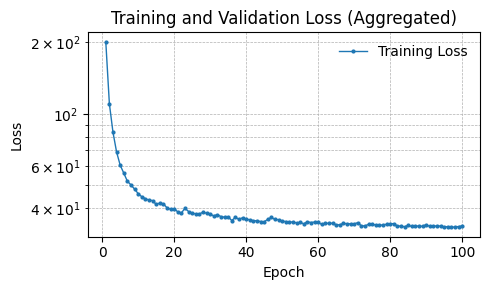

In [15]:
model.plot_losses(True)

In [16]:
def make_pos_grid(x0: int, y0: int, p: int, H: int, device):
    """Return a (1,2,p,p) tensor with x/y in [-1,1]."""
    xs = torch.arange(x0, x0 + p, device=device)
    ys = torch.arange(y0, y0 + p, device=device)
    xg = ((xs.view(1, -1).repeat(p, 1) / (H - 1)) - 0.5) * 2
    yg = ((ys.view(-1, 1).repeat(1, p) / (H - 1)) - 0.5) * 2
    return torch.stack([xg, yg], 0).unsqueeze(0)  # (1,2,p,p)

Sampling (prior): 100%|██████████| 100/100 [00:05<00:00, 19.25it/s, t=0.010, sigma=1.07e-02, |x|=9.41e-01]


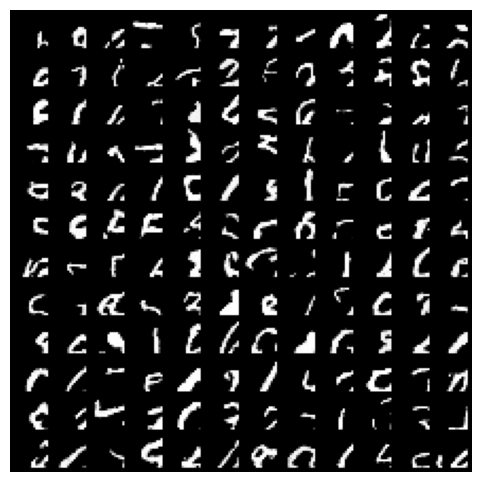

In [17]:
N = 144

pos_grid = make_pos_grid(0, 0, 16, 28, device).repeat(N, 1, 1, 1)
samples = model.sample(shape=[N, 1, 16, 16], steps=100, condition=[pos_grid])

sample_grid = make_grid(samples, nrow=int(np.sqrt(N)), value_range=(0, 1), normalize=True)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0, vmax=1)
plt.show()

Sampling (prior): 100%|██████████| 200/200 [00:07<00:00, 27.47it/s, t=0.005, sigma=1.04e-02, |x|=9.39e-01]


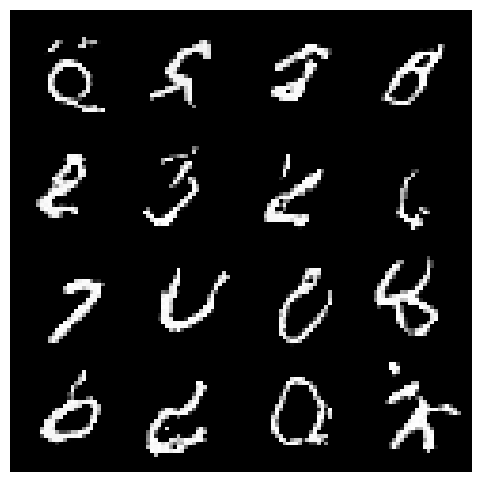

In [19]:
N = 16
samples = model.sample(shape=[N, 1, 28, 28], steps=200, patch_size=16, stride=6)

sample_grid = make_grid(samples, nrow=int(np.sqrt(N)), value_range=(0, 1), normalize=True)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0, vmax=1)
plt.show()

In [29]:
print(data[-1].max())

tensor(255, dtype=torch.uint8)


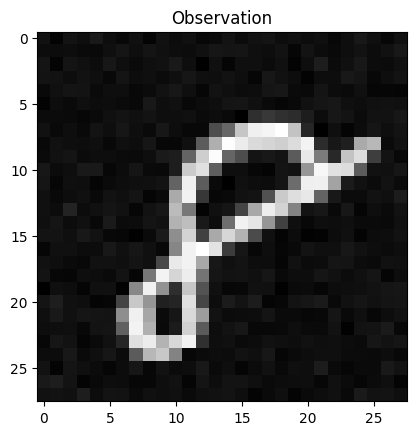

In [30]:
def llk_fn(t, x, model, forward_model, obs, sigma_n):
    with torch.enable_grad():
        if not x.requires_grad:
            x = x.clone().detach().requires_grad_(True)

        y = forward_model(x)
        res = obs - y
        sigma_inv_s = 1 / (model.sde.sigma(t) ** 2 + sigma_n ** 2)

        log_likelihood = - (res ** 2).sum(dim=[1, 2, 3])
        grad = torch.autograd.grad(log_likelihood.sum(), x, retain_graph=False)[0]
        grad = grad * sigma_inv_s.view(-1, 1, 1, 1)
    return grad


forward_model = lambda x: x

std = 0.05
img = data[-1].unsqueeze(0).unsqueeze(0) / 255. * 2 - 1
observation = img + torch.randn_like(img) * std
observation = observation.to(device)
plt.imshow(observation.squeeze().cpu(), cmap='gray')
plt.title("Observation")
plt.show()

llk_fn_identity = lambda t, x: llk_fn(t, x, model, forward_model, observation, std)

Sampling (posterior): 100%|██████████| 100/100 [00:04<00:00, 23.42it/s, t=0.010, sigma=1.07e-02, |x|=9.34e-01]


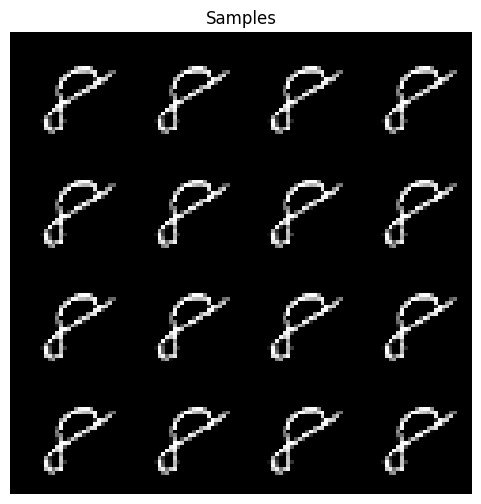

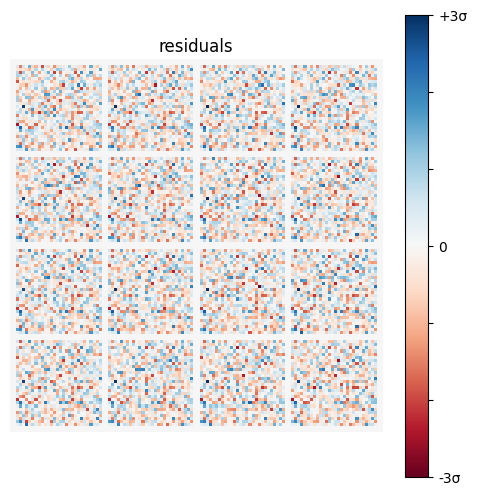

In [31]:
N = 16
samples = model.sample(shape=[N, 1, 28, 28], steps=100, patch_size=16, stride=12, likelihood_score_fn=llk_fn_identity)

sample_grid = make_grid(samples, nrow=int(np.sqrt(N)), value_range=(0, 1), normalize=True)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0, vmax=1)
plt.title("Samples")
plt.show()

sample_grid = make_grid(observation - samples, nrow=int(np.sqrt(N)))[0]

plt.figure(figsize=(6, 6))
plt.axis('off')
im = plt.imshow(sample_grid.cpu(), vmin=-3 * std, vmax=3 * std, cmap="RdBu")
cbar = plt.colorbar(im, ticks=[-3 * std, -2 * std, -1 * std, 0, 1 * std, 2 * std, 3 * std])
cbar.ax.set_yticklabels(['-3σ', '', '', '0', '', '', '+3σ'])
plt.title("residuals")
plt.show()